# NFL Overtime Simulation

Historically, the NFL has used "sudden death" rules in playoff overtime (first score wins). As such, it was extremely advantageous to possess the ball first in overtime. A simple field goal could win the game without ever letting the opponent get the ball.

In 2024, the playoff [rules](https://operations.nfl.com/the-rules/nfl-overtime-rules/) were changed to allow each team a possession at the start of overtime. If the score is tied after each team's initial posession, then the next score wins. Under these new rules, it's unclear if it's better to get the ball first or second. If you get the ball first, you get the ball again if the score is tied after the initial posessions and can win the game without the opponent going back on offense. If you get the ball second, you have more information on your drive and can use 4th downs more effectively. Let's build a simple simulation to see if either strategy is more advantageous.

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats
from NFLOvertimeSim import FootballTeam, FootballGame, FootballSimulation
from pprint import pprint


From google searching, [66% of series result in a first down](http://www.advancedfootballanalytics.com/2008/07/first-down-probability.html). To simulate plays, we're sampling random yardage results from a triangular distribution amd calculating the cumulative sum. We can define the triangluar distibution by supplying the minimum expected yards, most probable yards, and maximum expected yards for a team. This techniue is simple, but allows us to easily incorporate expert opinion. With this method, we can calculate the probability that the cumulative sum after 3 plays >= 10 (enough for a first down.) We're using 3 plays instead of 4 because most NFL teams punt or kick a field goal on 4th down.

We can then tune the min, avg, and max parameters of the triangular distribution to match the expected 1st down rate in actual NFL games.

To start, let's assume the minimum likely play is -15 yards (a personal foul penalty), the most likely is the league average team yards per play (6 yards), and the max likely is 25 yards (around the threshold for an "Explosive play")

"ax = sns.lineplot(data=df, x='sample_size', y='probability')\nax.fill_between(df.sample_size, df.low_ci, df.high_ci, alpha=0.6)\nplt.suptitle('Simulated First Down Sucess Rate Within 3 Downs')\nax.set_xlabel('Number of Trials')\nax.set_ylabel('First Down Probability')"

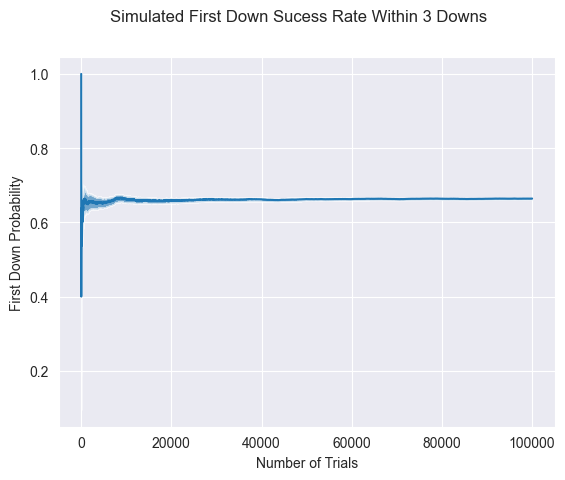

In [49]:
team = FootballTeam('team1', exp_yards=6, min_yards=-15, max_yards=25)
n_interations = 100000

np.random.seed(42)

def get_wilson_interval(proportions: np.ndarray, trials: np.ndarray, confidence_level=0.95):
    """Implements wilson score interval for binomial distribution. 
    Wald interval has been criticized because the CI can exceed 0 or 1 when the true sucess probabilty approaches 0 or 1, or when the sample size is small.
    Wilson score interval improves this
    """
    alpha = 1 - confidence_level
    z = stats.norm.ppf(1 - alpha / 2)

    A = 1 / (1 + (z ** 2) / trials)
    B = proportions + (z ** 2) / (2 * trials)
    C = 4 * trials * proportions * (1 - proportions) + z ** 2
    D = (z / (2 * trials)) * np.sqrt(C)

    low_ci = A * (B - D)
    high_ci = A * (B + D)

    return low_ci, high_ci

def binomial_ci(successes, trials, proportions, confidence_level=0.95):
    low = []
    high = []
    for k, n, p in zip(successes, trials, proportions):
        bt_res = stats.binomtest(k, n, p)
        ci = bt_res.proportion_ci(confidence_level)
        low.append(ci.low)
        high.append(ci.high)


    return low, high

def first_down_simulation(team: FootballTeam, n_interations=100000, n_plays=3) -> np.ndarray:
    """Simulates a football series many times and estimates the probability of converting a first down within n_plays"""

    series_yards = np.array([team.simulate_series(n_plays) for i in range(n_interations)])

    sample_sizes = np.arange(1, n_interations+1)

    # how many times would a team expect to gain at least 10 yards within 3 plays?
    first_down_cumsum = np.cumsum(series_yards >= 10)

    return first_down_cumsum


def event_probability_by_samplesize(data: np.ndarray, data_are_sums: bool=True) -> pd.DataFrame:
    """Takes a numpy array of either event or probability cumsums. If data are sums, it will convert them to probabilities.
    It also calculates confidence intervals per the wilson method

    Returns a df of the data
    """

    sample_sizes = np.arange(1, data.size + 1)

    probabilities = data / sample_sizes if data_are_sums else data

    low_ci, high_ci = get_wilson_interval(probabilities, sample_sizes)

    data_dict = {'sample_size': sample_sizes,
                'probability': probabilities,
                'low_ci': low_ci,
                'high_ci': high_ci}

    return pd.DataFrame(data_dict)

'Number of Trials', 'Average Win Percentage'

def simulation_probabilty_lineplot(df: pd.DataFrame, 
                                   title: str, 
                                   x_lab: str = 'Number of Trials', 
                                   y_lab: str = 'Average Win Percentage', 
                                   x: str='sample_size', 
                                   y: str='probability'):
    
    """Visualizes data from repeated monte carlo simulations by increasing sample size"""
    sns.set_style('darkgrid')
    ax = sns.lineplot(data=df, x='sample_size', y='probability')
    ax.fill_between(df.sample_size, df.low_ci, df.high_ci, alpha=0.6)
    plt.suptitle(title)
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)

    return ax

    

fd_cumsums = first_down_simulation(team)
df = event_probability_by_samplesize(fd_cumsums)

sns.set_style('darkgrid')
ax = simulation_probabilty_lineplot(df, 'Simulated First Down Sucess Rate Within 3 Downs', 'Number of Trials', 'First Down Probability')

"""ax = sns.lineplot(data=df, x='sample_size', y='probability')
ax.fill_between(df.sample_size, df.low_ci, df.high_ci, alpha=0.6)
plt.suptitle('Simulated First Down Sucess Rate Within 3 Downs')
ax.set_xlabel('Number of Trials')
ax.set_ylabel('First Down Probability')"""

In [8]:
np.arange(2).size

2

# Parameter Review
Settings of -15, 6, and 25 replicate the NFL first down rate reasonably well. The simulated probability seems to stabilize at 66% after 10K trials

We can experiment with other parameters later. Let's see how it simulates an actual drive. With these setting, ~61% of drives result in no points, 23% result in touchdowns, and 16% result in field goals. This also aligns with [historical NFL data](https://medium.com/@nickmartin812/nfl-probability-of-points-from-drives-part-1-cab7fc9cff0b). Let's simulate a game with these aprameters!

In [3]:
team = FootballTeam('team1', exp_yards=6, min_yards=-15, max_yards=25)

n_drives = 10000
for i in range(n_drives):
    team.simulate_drive(25, False)

last_plays_df = pd.concat([df.iloc[-1:, :] for df in team.get_drive_data()])
last_plays_df.points_from_play.value_counts() / n_drives

points_from_play
0    0.6158
7    0.2249
3    0.1593
Name: count, dtype: float64

# Overtime Simulation Demo

We're modeling an NFL drive as a random walk with the yardage gained on each play randomly drawn from the triangular distribution descibed above. Each drive will continue the team's random walk down the field until they've either scored a touchdown by reaching 100+ yards, or they reach fourth down. At fourth down, the team reaches a decision point:

* If the team needs a touch down to continue the game, they always go fo it
* If the user-defined field position and first down yardage criteria are met (default >= 45 yards field position,  <= 2 yards for first)
* If the team is in field-goal range and don't need a touch down, they will attempt a field goal
* If the team needs a field goal but is not in range, they will run a play
* Otherwise, the team will punt

We can also decide if the team chooses to go for 2 after a touchdown or not. This is modeled as a binary event with default sucess probability of 0.5. This will typically only be relevant for the team receiving the ball second if the first team has scored a touchdown.

For future work, we could enhance the simulations where each team looks ahead to calculate win probability, but this current implementation should be good enough for now. Here's an example game:

In [54]:
team1 = FootballTeam('The Vacaville Cow-tippers')
team2 = FootballTeam('The Boston Wicked Tuna', go_for_two=True)

game = FootballGame(team1, team2)
game.simulate_game()

pprint(game.game_data)

{'loser': 'The Boston Wicked Tuna',
 'losing_team_number_of_drives': 1,
 'total_yards_losing_team': np.float64(8.216401536427739),
 'total_yards_winning_team': np.float64(87.60027924280328),
 'winner': 'The Vacaville Cow-tippers',
 'winner_had_ball_first': True,
 'winner_score': 0,
 'winning_team_number_of_drives': 2}


In [60]:
simulation = FootballSimulation(team1_params, team2_params)
simulation.simulate_games(20)

simulation_df = simulation.summarize_df()
simulation_df.winner_had_ball_first.value_counts

win_counts = simulation_df.winner_had_ball_first.value_counts()
stats.chisquare(win_counts)

Power_divergenceResult(statistic=np.float64(0.8), pvalue=np.float64(0.37109336952269756))

In [59]:
win_counts = simulation_df.winner_had_ball_first.value_counts()
stats.chisquare(win_counts)

Power_divergenceResult(statistic=np.float64(1.8), pvalue=np.float64(0.17971249487899593))

# It's Simulation Time!
## Evenly matched teams, never go for 2

Let's simulate a bunch of games with equally matched teams to see if there's an advantage to going first.

Power_divergenceResult(statistic=np.float64(35.0464), pvalue=np.float64(3.2194161868684896e-09))


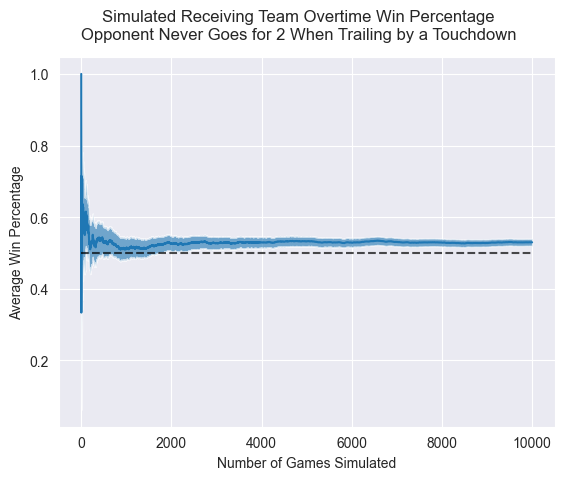

In [69]:
team1_params = {'name': 'receiving_team',
                'go_for_two': False}

team2_params = {'name': 'kicking_team',
                'go_for_two': False}

lineplot_titles = {'title': 'Simulated Receiving Team Overtime Win Percentage\nOpponent Never Goes for 2 When Trailing by a Touchdown',
                  'x_lab': 'Number of Games Simulated'}

n_games = 10000

def analyze_ball_first(team1_params, team2_params, lineplot_titles = {}, n_games=n_games):
    simulation = FootballSimulation(team1_params, team2_params)
    simulation.simulate_games(n_games)

    simulation_df = simulation.summarize_df()

    # chi suare test
    win_counts = simulation_df.winner_had_ball_first.value_counts()
    test_result = stats.chisquare(win_counts)

    pprint(test_result)

    ball_first_win_cumsum = simulation_df.winner_had_ball_first.cumsum()
    win_pct_df = event_probability_by_samplesize(ball_first_win_cumsum)

    ax = simulation_probabilty_lineplot(win_pct_df, **lineplot_titles)
    ax.hlines(0.5, 0, n_games, colors='k', linestyle='--', alpha=0.7)

    return win_pct_df, test_result, ax


opp_goes_for_one_df, opp_goes_for_one_test_result, opp_goes_for_one_ax = analyze_ball_first(team1_params, team2_params, lineplot_titles)

plt.savefig(os.path.join('Visualizations', 'opp_goes_for_one_plot.png'))

In [70]:
opp_goes_for_one_df.tail()

,sample_size,probability,low_ci,high_ci
9995,9996,0.529712,0.519918,0.539483
9996,9997,0.529659,0.519865,0.539430
9997,9998,0.529606,0.519813,0.539376
9998,9999,0.529553,0.519760,0.539323
9999,10000,0.529600,0.519808,0.539369


# Opponent Goes for Two if the Receiving Team Scores a TD

Seems like going first provides a ~3% advantage copared to going second when the team going second never tries for 2. However, most teams won't like the idea of handing the ball back to their opponent as sudden death starts, so most would prefer to go for 2 in this situation. Let's see what that does.

Power_divergenceResult(statistic=np.float64(16.9744), pvalue=np.float64(3.788723990110657e-05))


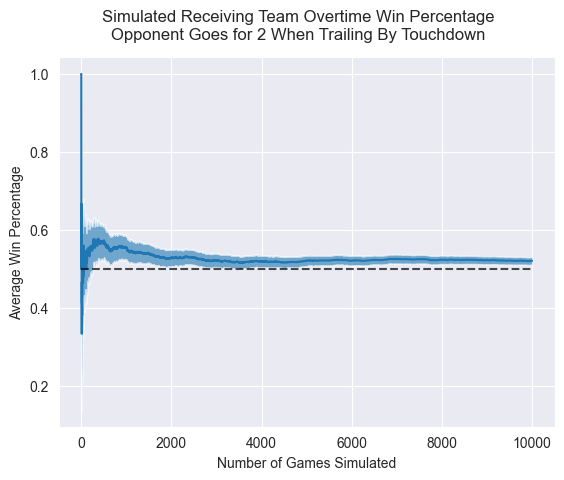

In [71]:
team1_params = {'name': 'receiving_team',
                'go_for_two': False}

team2_params = {'name': 'kicking_team',
                'go_for_two': True}

lineplot_titles = {'title': 'Simulated Receiving Team Overtime Win Percentage\nOpponent Goes for 2 When Trailing By Touchdown',
                  'x_lab': 'Number of Games Simulated'}

n_games = 10000

opp_goes_for_two_win_pct_df, opp_goes_for_two_test_result, opp_goes_for_two_ax = analyze_ball_first(team1_params, team2_params, lineplot_titles)
plt.savefig(os.path.join('Visualizations', 'opp_goes_for_two_plot.png'))

In [72]:
opp_goes_for_two_df.tail()

,winner,loser,winner_score,winner_had_ball_first,winning_team_number_of_drives,losing_team_number_of_drives,total_yards_winning_team,total_yards_losing_team
9995,receiving_team,kicking_team,6,True,1,1,80.539757,87.166095
9996,receiving_team,kicking_team,0,True,1,1,80.713775,9.349850
9997,kicking_team,receiving_team,0,False,1,1,34.865096,27.588376
9998,receiving_team,kicking_team,0,True,1,1,79.558132,16.466988
9999,kicking_team,receiving_team,0,False,1,1,60.931178,-19.022755


In [73]:
opp_goes_for_two_win_pct_df.tail()

,sample_size,probability,low_ci,high_ci
9995,9996,0.520508,0.510709,0.530292
9996,9997,0.520556,0.510757,0.530339
9997,9998,0.520604,0.510806,0.530387
9998,9999,0.520652,0.510854,0.530434
9999,10000,0.520600,0.510802,0.530382


# Conclusion

Given two identical teams playing eachother in the NFL's new playoff rules, the team receiving the ball first has a small but statistically significant advantage. If the opponent never goes for two points in response to an opening drive touchdown, the team receiving the ball first would expect a 3% increase in win probability compared to flipping a coin. 

If the opponent scores a touchdown and attempts a 2pt coversion with 50% sucess rate, the ball-first team still would expect a 2% increase in win probaility compared to flipping a coin. Both these increases were statistically significant at the 95% confidence interval.

# Future work
* Add effects of explosive plays to drives. These plays accoutn for <10% of all NFL plays.
* Account for team defenses
* Model penalties seperately from the expected play sampling
* Add Mahomes/Refs effect